## Problem 1 ##

Camera Intrinsic matrix:
[[934.61629644   0.         655.89841313]
 [  0.         935.62249359 376.69588351]
 [  0.           0.           1.        ]]

Extrensic Matrix for Image 1 :-

 Rotation Matrix:
[[ 0.99995539 -0.00672875  0.00662906]
 [ 0.00663206  0.99987284  0.01450215]
 [-0.0067258  -0.01445754  0.99987286]]

 Translation Vector:
[[-5.92917184]
 [-2.75903298]
 [13.68268509]]
-------------------------------------------------------------------

Extrensic Matrix for Image 2 :-

 Rotation Matrix:
[[ 0.99900096 -0.04464895 -0.00188298]
 [ 0.03574041  0.82355103 -0.56611512]
 [ 0.02682718  0.56548225  0.82432404]]

 Translation Vector:
[[-4.84350566]
 [-1.89339598]
 [ 9.56429019]]
-------------------------------------------------------------------

Extrensic Matrix for Image 3 :-

 Rotation Matrix:
[[ 0.99879312  0.01375138 -0.04715083]
 [ 0.0071345   0.90920152  0.4162952 ]
 [ 0.04859425 -0.41612918  0.90800611]]

 Translation Vector:
[[-4.47529209]
 [-3.40308952]
 [12.66954866]

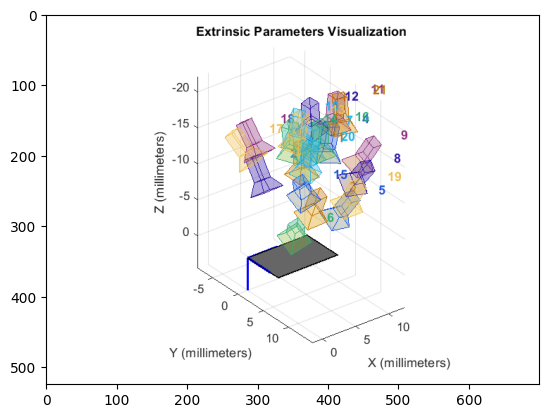

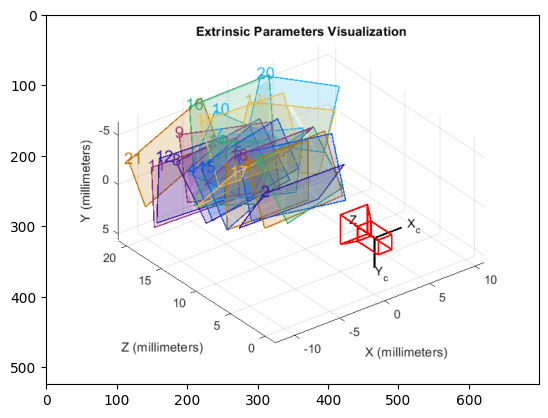

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import re

# I tired using an iphone but due to high res (12MP) it was taking too long
# Thus I decided to use my webcam and forced it to a 0.9MP (1280x720) and it speeded up the process  

CHECKERBOARD_DIM = (7,10)

SQUARE_DIM = 1

# Make corresponding 3D world points (assuming each square is 1 unit away)
# (0,0,0) (1,0,0) ... (6,0,0) (0,1,0)...(6,1,0) (0,9,0)..(6,9,0) Only inner points of checker
world_Points = np.zeros((1, CHECKERBOARD_DIM[0]* CHECKERBOARD_DIM[1],3), np.float32)
world_Points[0, :, :2] = np.mgrid[0:CHECKERBOARD_DIM[0],0:CHECKERBOARD_DIM[1]].T.reshape(-1, 2)

# All of the below is to match matlab point oredering 
#############################################
temp = world_Points[:,:,0].copy()
world_Points[:,:,0] = world_Points[:,:,1]
world_Points[:,:,1] = temp
#############################################

world_Points = world_Points*SQUARE_DIM

# array to store point pairs 
points_3D = []
points_Camera = []

# Get all jpg that start with checker
images = glob.glob('checker*.jpg')
images = sorted(images, key=lambda x:float(re.findall("(\d+)",x)[0]))

# iterate trough all checker images
for filename in images:
    img = cv.imread(filename)
 
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # Find corners
    ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD_DIM,None)
    
    #If corners are found refine the position
    if ret == True:
        
        # add corresponding 3D(world) cordinates 
        points_3D.append(world_Points)
          
        # Refining pixel coordinates
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), None)
        
        # All of the below is to match matlab point ordering
        #######################################################################################
        corners2 = corners2[::-1]
        corners3 = np.zeros_like(corners2)
        
        for i in range(0,CHECKERBOARD_DIM[0]*CHECKERBOARD_DIM[1]-1,CHECKERBOARD_DIM[0]):
            corners3[i:i+CHECKERBOARD_DIM[0],:,:] = corners2[i:i+CHECKERBOARD_DIM[0],:,:][::-1]
        ########################################################################################
    
        # add corresponding camera(pixel) points
        points_Camera.append(corners3)
        
        # Display the images with found corners
        cv.drawChessboardCorners(img, CHECKERBOARD_DIM,corners3, ret)
        cv.imshow(filename, img)
        cv.waitKey(0)
        cv.destroyAllWindows()
    else:
        print("No Corners Found for {}".format(filename))
    
    

# Once we have all point pairs I use the built in function of OpenCV to find intrinsic and extrinsic matrix for each Image
ret, matrix, distortion, r_vecs, t_vecs = cv.calibrateCamera(points_3D, points_Camera, gray.shape[::-1], None, None)

# Displaying Intrinsic Matrix (focal length and scale)
print("Camera Intrinsic matrix:")
print(matrix)

r_mat = []
# Displaying unique extrinsic matrix for each images (rotation matix and translation vector)
# OpenCV returns a rotation vector and must be converted to rotation matrix
for i in range(len(r_vecs)):
    
    r_mat_i = np.zeros((3,3))
    cv.Rodrigues(r_vecs[i],r_mat_i)
    r_mat.append(r_mat_i)
    
    print("\nExtrensic Matrix for Image {0} :-".format(i+1))
    
    print("\n Rotation Matrix:")
    print(r_mat[i])
    
    print("\n Translation Vector:")
    print(t_vecs[i])
    
    print("-------------------------------------------------------------------")
    
# OPenCV or python has no built-in function to show extrinsinc param in one plot. 
# Thus I used Matlab to make the graph using Camera Calibration tool
# The results for focal length and intrinsic matrix match with certain margin of error.
# However Matlab has origin of corners in top left and OpenCv in top right
# Causing some extrinsinc param to differ. Thus I reaaranged points above to match MATLAB 
# I will just dispaly the plot generated by matlab and alos attach the matlab script seperately.

pattern = cv.imread("patternCentric.png")
plt.imshow(pattern)
plt.show()

camera = cv.imread("cameraCentric.png")
plt.imshow(camera)
plt.show()

## Problem 2 ##

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines

def midpoint (leftRay, rightRay , l_R_r , l_t_r):
    # a*leftRay + c (leftRay X l_R_r*rightRay) = b*l_R_r*rightRay + l_t_r
    # a*leftRay + c (q) = b*l_R_r*rightRay + l_t_r
    
    q = np.cross(leftRay,np.matmul(l_R_r,rightRay)) # segmet between right and left ray
    q = q/np.linalg.norm(q) # normalize the cross product or segemtn between right ray and left ray
    
    # gattering everything to one side
    # a*leftRay + c (q) - b*l_R_r*rightRay = l_t_r
    # A [a b c].T = l_t_r
    A = np.vstack((leftRay,-1*np.matmul(l_R_r,rightRay),q)).T
    
    # [a b c].T = inv(A) * l_t_r
    sol = np.matmul(np.linalg.inv(A), l_t_r) 
    
    a = sol[0]
    b = sol[1]
    c = sol[2]
    
    # mid point is a*leftRay + 0.5*c(q) --> Halfway between right camera ray and left camera ray
    midpoint_sol = a*leftRay + c*0.5*q
    
    return midpoint_sol
    
    

def reconstruct3D (leftRays, rightRays, l_R_r , l_t_r , w_M_l):
    
    points_3D = np.zeros((len(leftRays[0]),len(w_M_l)))
    
    for i in range(len(leftRays[0])):
        # Find mid point of two rays wrt to left camera
        midpoint_wrt_left = midpoint(leftRays[:,i].T, rightRays[:,i], l_R_r, l_t_r)
        midpoint_wrt_left = np.hstack((midpoint_wrt_left,[1]))
        
        # Find the mid point wrt to world
        midpoint_wrt_world = np.matmul(w_M_l,midpoint_wrt_left) 

        # Add it to output 
        points_3D[i] = midpoint_wrt_world.T
        
    return points_3D

def plot3D (pts,title):
    x = pts[:,0]
    y = pts[:,1]
    z = pts[:,2]
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.plot([x[0],x[1]],[y[0],y[1]],[z[0],z[1]],'b')
    ax.plot([x[1],x[2]],[y[1],y[2]],[z[1],z[2]],'b')
    ax.plot([x[2],x[3]],[y[2],y[3]],[z[2],z[3]],'b')
    ax.plot([x[3],x[0]],[y[3],y[0]],[z[3],z[0]],'b')
    
    ax.plot([x[4],x[5]],[y[4],y[5]],[z[4],z[5]],'b')
    ax.plot([x[5],x[6]],[y[5],y[6]],[z[5],z[6]],'b')
    ax.plot([x[6],x[7]],[y[6],y[7]],[z[6],z[7]],'b')
    ax.plot([x[7],x[4]],[y[7],y[4]],[z[7],z[4]],'b')
    
    ax.plot([x[0],x[4]],[y[0],y[4]],[z[0],z[4]],'b')
    ax.plot([x[1],x[5]],[y[1],y[5]],[z[1],z[5]],'b')
    ax.plot([x[2],x[6]],[y[2],y[6]],[z[2],z[6]],'b')
    ax.plot([x[3],x[7]],[y[3],y[7]],[z[3],z[7]],'b')
    plt.title(title)
    plt.show()

def plot2D (pts,title):
    x = pts[:,0]
    y = pts[:,1]
    z = pts[:,2]
    
    fig = plt.figure()
    ax = plt.axes()
    
    ax.plot([x[0],x[1]],[y[0],y[1]],'b')
    ax.plot([x[1],x[2]],[y[1],y[2]],'b')
    ax.plot([x[2],x[3]],[y[2],y[3]],'b')
    ax.plot([x[3],x[0]],[y[3],y[0]],'b')
    
    ax.plot([x[4],x[5]],[y[4],y[5]],'b')
    ax.plot([x[5],x[6]],[y[5],y[6]],'b')
    ax.plot([x[6],x[7]],[y[6],y[7]],'b')
    ax.plot([x[7],x[4]],[y[7],y[4]],'b')
    
    ax.plot([x[0],x[4]],[y[0],y[4]],'b')
    ax.plot([x[1],x[5]],[y[1],y[5]],'b')
    ax.plot([x[2],x[6]],[y[2],y[6]],'b')
    ax.plot([x[3],x[7]],[y[3],y[7]],'b')
    plt.title(title)
    plt.show()

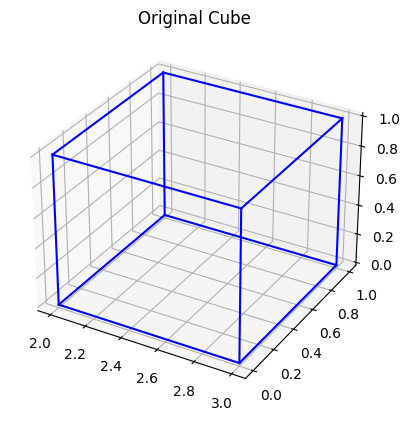

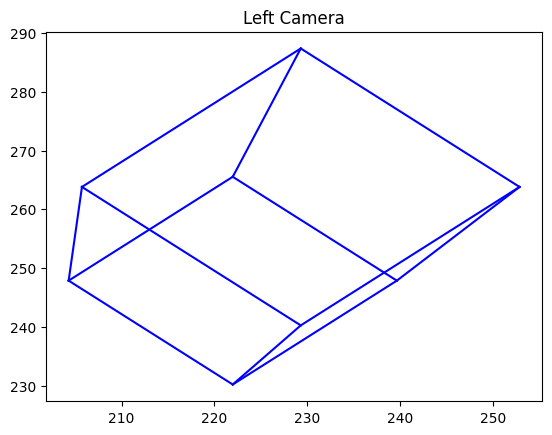

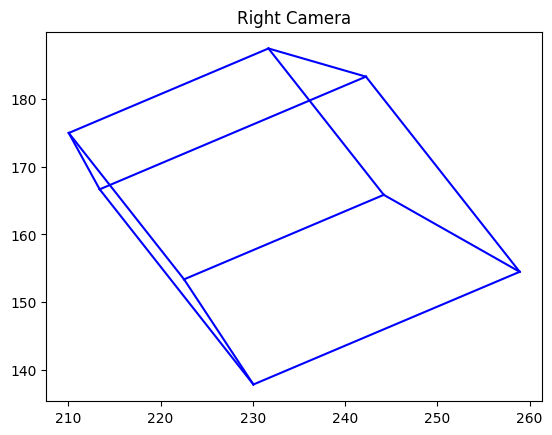

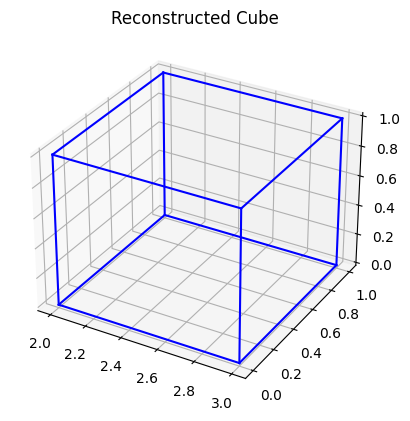


Ground Truth (Orginal Points) :- 
[[2.  0.  0. ]
 [3.  0.  0. ]
 [3.  1.  0. ]
 [2.  1.  0. ]
 [2.  0.  1. ]
 [3.  0.  1. ]
 [3.  1.  1. ]
 [2.  1.  1. ]
 [2.5 0.5 2. ]]

Reconstructed Points :-
[[ 2.00000000e+00 -6.66133815e-16 -4.44089210e-16]
 [ 3.00000000e+00  3.33066907e-16 -4.44089210e-16]
 [ 3.00000000e+00  1.00000000e+00 -2.66453526e-15]
 [ 2.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 2.00000000e+00 -8.88178420e-16  1.00000000e+00]
 [ 3.00000000e+00  4.44089210e-16  1.00000000e+00]
 [ 3.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 2.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 2.50000000e+00  5.00000000e-01  2.00000000e+00]]

Absolute error btw points :-
[[2.22044605e-16 6.66133815e-16 4.44089210e-16]
 [4.44089210e-16 3.33066907e-16 4.44089210e-16]
 [1.33226763e-15 5.55111512e-16 2.66453526e-15]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.44089210e-16 8.88178420e-16 8.88178420e-16]
 [8.88178420e-16 4.44089210e-16 8.88178420e-16]
 [1.33226763e-15 2.2204460

In [6]:
K = np.array([ [-100, 0    , 200],
               [0   , -100 , 200],
               [0   , 0    , 1]])

M_EXT_L = np.array([[0.707  , 0.707, 0, -3  ],
                  [-0.707 , 0.707, 0, -0.5],
                  [0,        0,    1,  3  ]])

M_EXT_R = np.array([[0.866  , -0.5,  0, -3  ],
                  [0.5   , 0.866, 0, -0.5],
                  [0      , 0    , 1,  3  ]])

PTS = np.array([[2,0,0],
                [3,0,0],
                [3,1,0],
                [2,1,0],
                [2,0,1],
                [3,0,1],
                [3,1,1],
                [2,1,1],
                [2.5,0.5,2]])

 
plot3D(PTS,'Original Cube')  

LEFT_PIXELS = np.zeros_like(PTS)
RIGHT_PIXELS = np.zeros_like(PTS)

# calculte camera cordinates using right camera and left camera refrence frame
for i in range(len(PTS)) :
    pixel = np.matmul(K,np.matmul(M_EXT_L,np.hstack((PTS[i],[1]))))
    LEFT_PIXELS[i] = pixel / pixel[2]
    pixel = np.matmul(K,np.matmul(M_EXT_R,np.hstack((PTS[i],[1]))))
    RIGHT_PIXELS[i] = pixel / pixel[2]

plot2D(LEFT_PIXELS,'Left Camera')
plot2D(RIGHT_PIXELS,'Right Camera')

# Assuming only left and right camera pixels are known
# Reconstruct 3D points

# Find ray for each point for each camera

LEFT_RAY = np.matmul(np.linalg.inv(K),LEFT_PIXELS.T)
RIGHT_RAY = np.matmul(np.linalg.inv(K),RIGHT_PIXELS.T)

L_M_W = np.vstack((M_EXT_L,[0,0,0,1]))
W_M_L = np.linalg.inv(L_M_W)

R_M_W = np.vstack((M_EXT_R,[0,0,0,1]))
W_M_R = np.linalg.inv(R_M_W)

# Matrix that turns all pixels in right camera to left camera
L_M_R = np.matmul(L_M_W , W_M_R)
L_ROTATION_R = L_M_R [0:3,0:3]
L_TRANSLATION_R = L_M_R [0:3,3:4]

reconst_3D = reconstruct3D(LEFT_RAY,RIGHT_RAY,L_ROTATION_R,L_TRANSLATION_R,W_M_L)
reconst_3D = reconst_3D[:,0:3] 

plot3D(reconst_3D,"Reconstructed Cube")  

print("\nGround Truth (Orginal Points) :- ")
print(PTS)

print("\nReconstructed Points :-")
print(reconst_3D)

print("\nAbsolute error btw points :-")
print(abs(PTS - reconst_3D))


# proj. error = || Origninal - Reconstructed ||

print("\nProjection Error :-")
print(np.linalg.norm(PTS - reconst_3D)**2)